## Opgave 3
## 3.1.1

In [123]:
# First, import the modules you want to use:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
from probfit import BinnedLH, Chi2Regression, Extended, UnbinnedLH # Helper tool for fitting
import sys
import scipy
from scipy import stats
from scipy.special import erfc
import re
sys.path.append('../External_Functions')
from ExternalFunctions import nice_string_output, add_text_to_ax # useful functions to print fit results on figure

In [124]:
def func(x, a, c):
    return c*(1-np.exp(-a*x))

def func_extended(x, a, c, N):
    return N * (c*(1-np.exp(-a*x)))

def fit_func(x, a):
    return 0.6627*(1-np.exp(-a*x))

def fit_func_extended(x, a, N):
    return N * (0.6627*(1-np.exp(-a*x)))

def gauss_pdf(x, mu, sigma):
    """Normalized Gaussian"""
    return 1 / np.sqrt(2 * np.pi) / sigma * np.exp(-(x - mu) ** 2 / 2. / sigma ** 2)


def gauss_extended(x, N, mu, sigma) :
    """Non-normalized Gaussian"""
    return N * gauss_pdf(x, mu, sigma)


xmin, xmax = 0, 2
a = 2
r = np.random
r.seed(42)

Writing the expression and solving for C as such:
$1=C\cdot\int^2_0f(x)dx$

And that gives: C = .6626212230

To get the mean and RMS of the PDF we calculate a bunch of numbers and take the mean with numpy. The RMS is calculated according to the following:

$RMS_y = \sqrt{\frac{1}{N}(y_1 + y_2 + y_n)}$

In [125]:
x = np.linspace(0,2,1000)
y = np.array(func(0.66, 2, x))
mean = np.mean(y)
RMS = np.sqrt( 1/len(y)*sum(y**2) )
print(f"Mean: {mean:.8f} and RMS {RMS:.19f}")

Mean: 0.73286470 and RMS 0.8464510064747945428


We can also calculate RMS as $rms^2 = \mu^2 + \sigma^2$ (notice however that it is $\widehat{\sigma} ^2$ and not $\widehat{\sigma}_{\mu}^2$)

In [126]:
np.sqrt( mean**2 + (np.std(y))**2 )

0.8464510064747947

And as we can see we get the same result

### 3.1.2
there I'll use the transformation method, since its the most effecient one, and that the function is easily invertable to integratable

Integrating f(x) gives C*(x+e^-ax/a) and inverting gives 1 / (C*(x+e^-ax/a))

In [127]:
C=0.6626212230
a=2
N_numbers = 500

def inv_func(x, c, a):
    return 1/ (C* ( x+ np.exp(-a*x)/a ) ) 

In [128]:
y_trans   = np.zeros(N_numbers)
x_trans = np.linspace(0,2,500)

for i in range(N_numbers):
    y_trans[i] = inv_func(r.uniform(low=0, high=2), C, a)

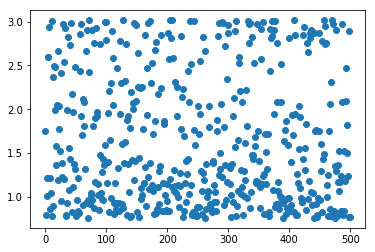

In [129]:
plt.plot(y_trans, 'o')

In [130]:
#Hit and miss method:

#for i in range(N_points):
r.seed(43)
expcos_x = []
expcos_y = []
xcos = np.zeros(N_numbers)

def run_da_points_mon():
    N_try = 0
    for i in range(N_numbers):
    
        while True:
        
            # Count the number of tries, to get efficiency/integral
            N_try += 1                    
        
            # Range that f(x) is defined/wanted in
            x2 = r.uniform(xmin, xmax)
        
            # Upper bound for function values (a better bound exists!)
            y2 = r.uniform(0, 0.8)        
        
            if (y2 < func(x2, a, C)):
                break
            
        xcos[i] = x2
        expcos_x.append(x2)
        expcos_y.append(y2)
    return N_try, expcos_x, expcos_y
        
N_try, x_list, y_list = run_da_points_mon()






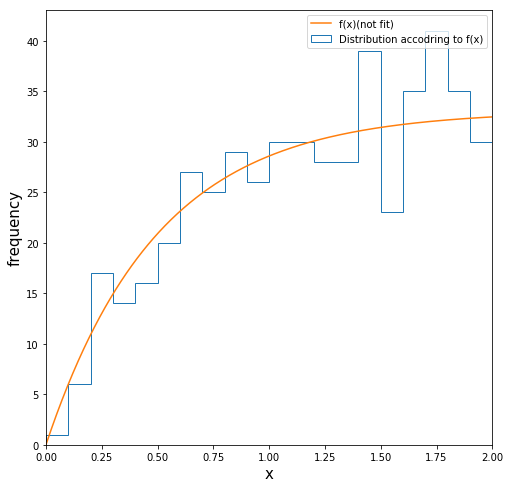

In [131]:
fig2, ax2 = plt.subplots(figsize=(8, 8))
hist_L30cm = ax2.hist(xcos, bins=20, range=(xmin, xmax), histtype='step', label='Distribution accodring to f(x)', density=False)
ax2.set(xlabel="x (distributed according to f(x))", ylabel="Frequency", xlim=(xmin, xmax));
L30cm_x, L30cm_y, L30cm_sy = get_bincenter_and_counts_in_range(hist_L30cm, min(xcos), max(xcos))
L30cm_binwidth = L30cm_x[1] - L30cm_x[0]

x_vals = np.linspace(0,2,500)
y_vals = func_extended(x_vals, a, C, L30cm_y.sum()*L30cm_binwidth)
ax2.set_xlabel("x", fontsize=15)
ax2.set_ylabel('frequency', fontsize=15)
ax2.plot(x_vals, y_vals, '-', label='f(x)(not fit)')
ax2.legend()
#fig2.savefig('3_1_3.png', dpi=300)

### 3.1.4

In [132]:
def get_bincenter_and_counts_in_range(hist, xmin=None, xmax=None):
    
    if xmin is None:
        xmin = np.min(hist)
    if xmax is None:
        xmax = np.max(hist)
    
    counts, bin_edges, _ = hist
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    mask1 = (xmin < bin_centers) & (bin_centers <= xmax) 
    mask2 = counts > 0
    mask_final = mask1 & mask2
    return bin_centers[mask_final], counts[mask_final], np.sqrt(counts[mask_final])

def calculate_chi2(function, x_values, y_values, sy_values, *fitparameters):
    # traditional loop-version
    chi2_val = 0
    entries = 0
    for x, y, sy in zip(x_values, y_values, sy_values):
        if y > 0:
            f = function(x, *fitparameters) # calc the model value
            residual  = ( y-f ) / sy  # find the uncertainty-weighted residual
            chi2_val += residual**2  # the chi2-value is the squared residual
            entries += 1 # count the bin as non-empty since sy>0 (and thus y>0)
    
    # numpy version
    mask = (y_values>0)
    yhat = function(x_values, *fitparameters)
    chi2_val = np.sum( (y_values[mask]-yhat[mask])**2/sy_values[mask]**2)
    entries = sum(mask)
            
    return chi2_val, entries


In [133]:

fit_x = np.array(x_list)
fit_y = np.array(y_list)
#fit_err = np.empty_like(fit_y)
#fit_err.fill(0.05)
fit_err = np.sqrt(fit_y)

#hist_L30cm = ax2.hist(xcos, bins=20, range=(xmin, xmax), histtype='step', label='histogram', density=True)
L30cm_x, L30cm_y, L30cm_sy = get_bincenter_and_counts_in_range(hist_L30cm, min(xcos), max(xcos))
L30cm_binwidth = L30cm_x[1] - L30cm_x[0]

new_L30cm = np.array(xcos)
chi2_L30cm = Chi2Regression(fit_func_extended, L30cm_x, L30cm_y, L30cm_y) 
fit_minuit = Minuit(chi2_L30cm, pedantic=False, a=1, N=L30cm_y.sum()*L30cm_binwidth, print_level=1)
fit_minuit.migrad();



#fit_chi2 = Chi2Regression(fit_func, fit_x, fit_x, fit_err)
#fit_minuit = Minuit(fit_chi2, pedantic=False, a=2, print_level=1) 
#fit_minuit.migrad();

# the fitted values of the parameters
#fit_a = fit_minuit.args

FCN = 0.48271140259782724 
 TOTAL NCALL = 43 
 NCALLS = 43 
 
 
 EDM = 3.934446067223511e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,a,1.57685,1.54402,,,,,No
1,N,51.7164,25.1786,,,,,No


In [134]:
x = np.linspace(0,2,500)
y = fit_func_extended(x, *fit_minuit.args)

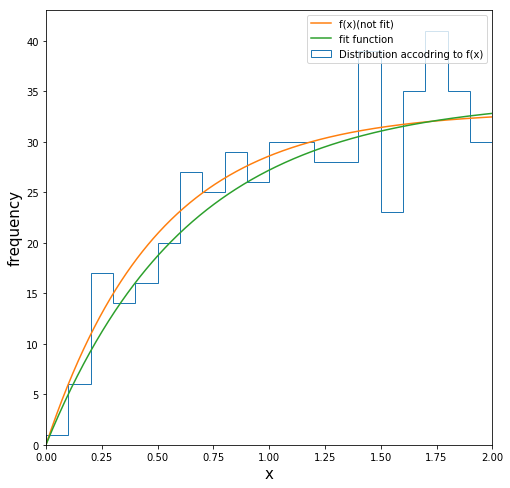

In [135]:
ax2.plot(x, y, label='fit function')
ax2.legend()
fig2
#fig2.savefig('3_1_4.png', dpi=300)

In [136]:
# Compute the chi2, the number of non-empty bins, the NDOF and the chi2-probability
fit_chi2, ob1_entries = calculate_chi2(fit_func_extended, L30cm_x, L30cm_y, L30cm_sy, *fit_minuit.args)
fit_NDOF = ob1_entries - len(fit_minuit.args)
fit_chi2_prob =  stats.chi2.sf(fit_chi2, fit_NDOF)
fit_chi2_prob

0.8150205117721597

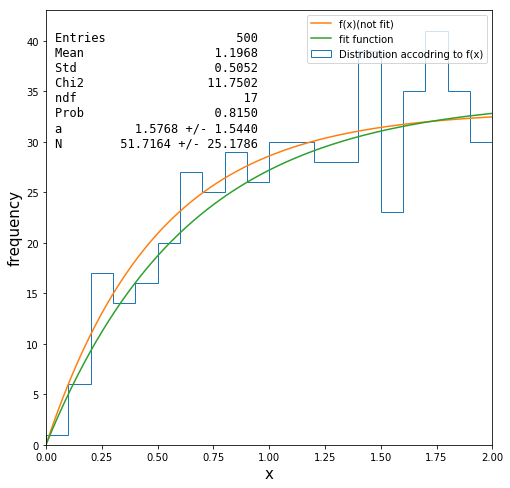

In [137]:
#30cm make the results ready to be plotted
d = {'Entries': len(new_L30cm), 
     'Mean': new_L30cm.mean(), 
     'Std': new_L30cm.std(ddof=1), 
     'Chi2': fit_chi2, 
     'ndf': fit_NDOF, 
     'Prob': fit_chi2_prob, 
    }
for name in fit_minuit.parameters:
    d[name] = [fit_minuit.values[name], fit_minuit.errors[name]]

# add these results to the plot 
text = nice_string_output(d, extra_spacing=2, decimals=4)
add_text_to_ax(0.02, 0.95, text, ax2, fontsize=12)

ax2.legend()

# show the actual fit and fit results

fig2.savefig('3_1_4.pdf', dpi=300)
fig2

In [138]:
def pick_u(amount, valSet, isum):
    item = np.zeros(amount)
    for i in range(amount):
        item[i] = sum(valSet[r.randint(0, 499, isum)])
    return item

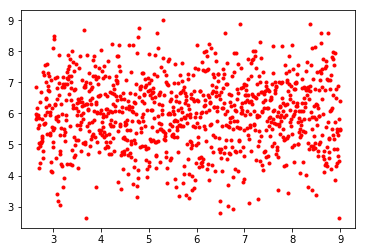

In [161]:
u = pick_u(1000, xcos, 5)

x = np.linspace(min(u), max(u), 1000)

plt.plot(x,u, 'r.')

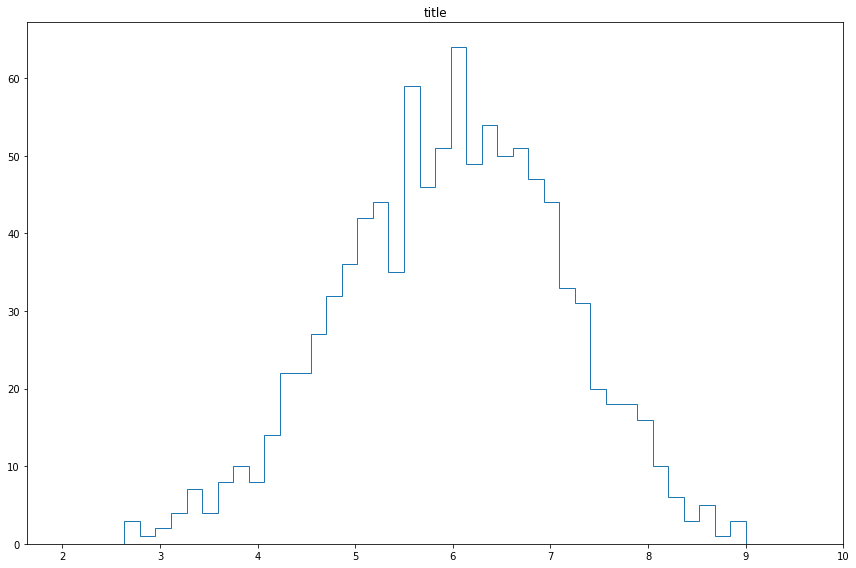

In [165]:
xLims = (min(u), max(u))
fig, ax = plt.subplots( figsize=(12,8))        
ax.hist(u, bins=40, range=xLims, histtype='step')
ymax = ax.get_ylim()[1]*1.2
ax.set(title='title', xlim=(min(u)-1, max(u)+1))

fig.tight_layout()

In [166]:
def QND(f_ax, f_x, f_y, f_min=0, f_max=1, f_title='the title', f_ylabel='y-label', f_xlabel='x_label'):
    t_hist = f_ax.hist(f_y, bins=40, range=(f_min, f_max), histtype='step', label='Binned Data')#, weights=1/new_eL30cm)
    f_ax.set(xlabel=f_xlabel, ylabel=f_ylabel, title=f_title)
    t_x, t_y, t_sy = get_bincenter_and_counts_in_range(t_hist, f_min, f_max)
    t_binwidth = t_x[1] - t_x[0]
    t_chi2 = Chi2Regression(gauss_extended, t_x, t_y, t_sy) 
    t_minuit = Minuit(t_chi2, pedantic=False, N=f_y.sum()*t_binwidth, mu=f_y.mean(), sigma=f_y.std(ddof=1), print_level=0) 
    t_minuit.migrad();
    t_fit_N, t_fit_mu, t_fit_sigma = t_minuit.args 
    t_xaxis = np.linspace(min(f_y), max(f_y), 10000)
    t_yaxis = gauss_extended(t_xaxis, *t_minuit.args)
    t_chi2, t_entries = calculate_chi2(gauss_extended, t_x, t_y, t_sy, *t_minuit.args)
    t_NDOF = t_entries - len(t_minuit.args)
    t_chi2_prob =  stats.chi2.sf(t_chi2, t_NDOF) 
    f_ax.plot(t_xaxis, t_yaxis, '-', label='Fit')
    f_ax.set_xlim([min(f_y)-0.5,max(f_y)+0.5])
    d = {'Entries': len(f_y),'Mean': f_y.mean(),'Std': f_y.std(ddof=1),'Chi2': t_chi2,'ndf': t_NDOF, 'Prob': t_chi2_prob,}
    for name in t_minuit.parameters:
        d[name] = [t_minuit.values[name], t_minuit.errors[name]]
    text = nice_string_output(d, extra_spacing=2, decimals=4)
    add_text_to_ax(0.02, 0.95, text, f_ax, fontsize=12)
    f_ax.legend()

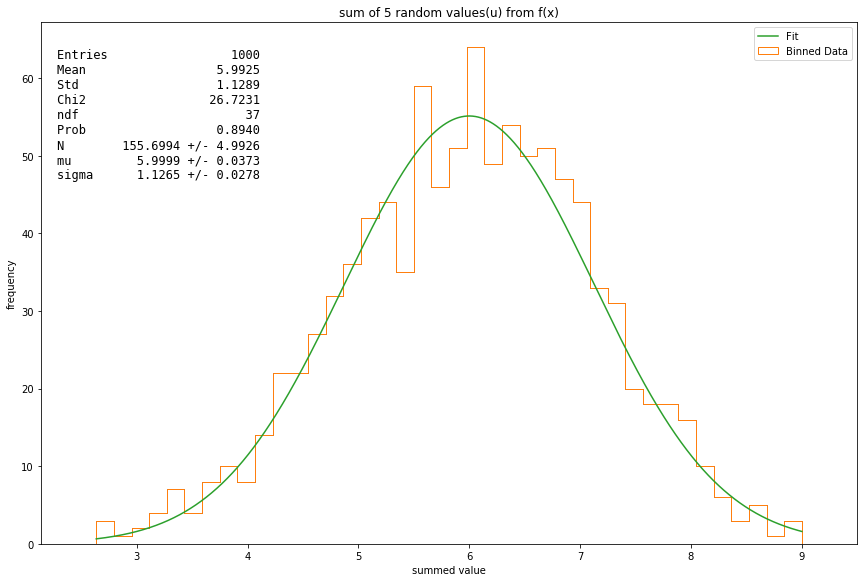

In [167]:
QND(ax, x, u, f_min=min(u), f_max=max(u), f_title='sum of 5 random values(u) from f(x)', f_ylabel='frequency', f_xlabel='summed value')

fig.savefig('guassSum.pdf', dpi=300)
fig

In [21]:
"""expcos_x = []
expcos_y = []
xcos = np.zeros(N_points)
def run_da_points_mon(maxVal, c):
    N_try = 0
    for i in range(N_points):
    
        while True:
        
            # Count the number of tries, to get efficiency/integral
            N_try += 1                    
        
            # Range that f(x) is defined/wanted in
            x2 = r.uniform(xmin, xmax)
        
            # Upper bound for function values (a better bound exists!)
            y2 = r.uniform(0, 1)        
        
            if (y2 < func(c, a, x2)):
                break
            
        xcos[i] = x2
        expcos_x.append(x2)
        expcos_y.append(y2)
    return N_try, expcos_x, expcos_y
        
N_try, _, _ = run_da_points_mon(1, 3.08)"""

'expcos_x = []\nexpcos_y = []\nxcos = np.zeros(N_points)\ndef run_da_points_mon(maxVal, c):\n    N_try = 0\n    for i in range(N_points):\n    \n        while True:\n        \n            # Count the number of tries, to get efficiency/integral\n            N_try += 1                    \n        \n            # Range that f(x) is defined/wanted in\n            x2 = r.uniform(xmin, xmax)\n        \n            # Upper bound for function values (a better bound exists!)\n            y2 = r.uniform(0, 1)        \n        \n            if (y2 < func(c, a, x2)):\n                break\n            \n        xcos[i] = x2\n        expcos_x.append(x2)\n        expcos_y.append(y2)\n    return N_try, expcos_x, expcos_y\n        \nN_try, _, _ = run_da_points_mon(1, 3.08)'

In [22]:
"""fig2, ax2 = plt.subplots(figsize=(10, 6))
hist_L30cm = ax2.hist(xcos, bins=50, range=(xmin, xmax), histtype='step', label='histogram' )
ax2.set(xlabel="x (distributed according to f(x))", ylabel="Frequency", xlim=(xmin, xmax));
#fig2.savefig('basopikussen.pdf', dpi=300)"""

'fig2, ax2 = plt.subplots(figsize=(10, 6))\nhist_L30cm = ax2.hist(xcos, bins=50, range=(xmin, xmax), histtype=\'step\', label=\'histogram\' )\nax2.set(xlabel="x (distributed according to f(x))", ylabel="Frequency", xlim=(xmin, xmax));\n#fig2.savefig(\'basopikussen.pdf\', dpi=300)'